In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import scipy.linalg
import time
import torch
import warp as wp
import open3d as o3d

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from example_sim_neo_hookean import Example

Warp 0.8.0 initialized:
   CUDA Toolkit: 11.5, Driver: 11.4
   Devices:
     "cpu"    | x86_64
     "cuda:0" | Quadro P4000 (sm_61)
   Kernel cache: /home/motion/.cache/warp/0.8.0


In [3]:
stage_path = os.path.join("outputs/example_sim_neo_hookean.usd")

example = Example(stage_path)

In [4]:
for i in range(example.sim_frames):
    example.update()

    curr_state = example.state_0
    curr_particle_q = curr_state.particle_q.numpy()

    # if i % 20 == 0:
    #     pcd = o3d.geometry.PointCloud()
    #     pcd.points = o3d.utility.Vector3dVector(curr_particle_q)
    #     o3d.visualization.draw_geometries([pcd])

	Module example_sim_neo_hookean load on device 'cuda:0' took 1.57 ms
	Module warp.sim.integrator_euler load on device 'cuda:0' took 47.92 ms
simulate took 57.01 ms
simulate took 6.64 ms
simulate took 6.37 ms
simulate took 6.53 ms
simulate took 6.58 ms
simulate took 6.56 ms
simulate took 6.25 ms
simulate took 6.21 ms
simulate took 6.12 ms
simulate took 6.23 ms
simulate took 6.24 ms
simulate took 6.22 ms
simulate took 6.31 ms
simulate took 6.26 ms
simulate took 6.16 ms
simulate took 6.53 ms
simulate took 6.19 ms
simulate took 6.37 ms
simulate took 6.20 ms
simulate took 6.10 ms
simulate took 6.03 ms
simulate took 6.10 ms
simulate took 7.14 ms
simulate took 8.49 ms
simulate took 6.32 ms
simulate took 6.21 ms
simulate took 7.98 ms
simulate took 9.38 ms
simulate took 6.48 ms
simulate took 6.29 ms
simulate took 6.24 ms
simulate took 6.11 ms
simulate took 6.17 ms
simulate took 6.48 ms
simulate took 7.20 ms
simulate took 6.10 ms
simulate took 6.08 ms
simulate took 6.49 ms
simulate took 6.12 ms


### Example to load mesh models

In [ ]:
from warp.sim.model import Mesh

# load triangle mesh
o3d_mesh = o3d.io.read_triangle_mesh("assets/rest_mesh.stl")

verts = np.array(o3d_mesh.vertices)
faces = np.array(o3d_mesh.triangles)

wp_mesh = Mesh(verts, faces.reshape(-1))

### Example to compute material parameters gradient

In [14]:
from warp.sim.integrator_euler import compute_forces, eval_tetrahedra

In [51]:
from example_sim_grid_deform import eval_linear_tetrahedra

In [46]:
time_id = 1684463289

In [7]:
particle_q_init = np.load(f'outputs/box_deform_{time_id}/particle_q_init.npy')
particle_f_init = np.load(f'outputs/box_deform_{time_id}/particle_f_init.npy')

In [47]:
particle_q_lst = []
particle_v_lst = []
particle_f_lst = []

for idx in range(300):
    x = np.load(f'outputs/box_deform_{time_id}/particle_q_{idx}.npy')
    particle_q_lst.append(x)

    v = np.load(f'outputs/box_deform_{time_id}/particle_qd_{idx}.npy')
    particle_v_lst.append(v)

    f = np.load(f'outputs/box_deform_{time_id}/particle_f_{idx}.npy')
    particle_f_lst.append(f)

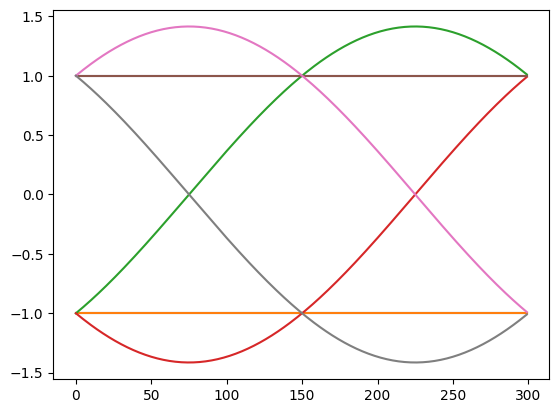

In [48]:
for idx in range(8):
    plt.plot([x[idx, 2] for x in particle_q_lst])
plt.show()

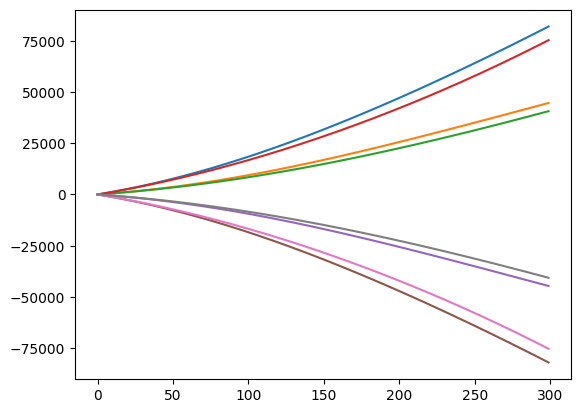

In [49]:
for idx in range(8):
    plt.plot([f[idx, 2] for f in particle_f_lst])
plt.show()

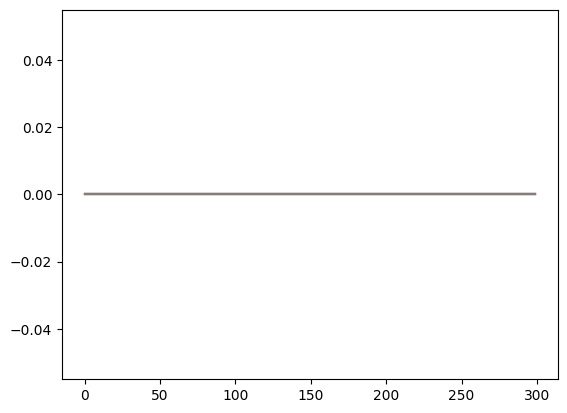

In [50]:
for idx in range(8):
    plt.plot([v[idx, 2] for v in particle_v_lst])
plt.show()

In [400]:
builder = wp.sim.ModelBuilder()

cell_dim = 1
cell_size = 2.0 / cell_dim

center = cell_size * cell_dim * 0.5

builder.add_soft_grid(
    pos=(-center, 0.0, -center),
    rot=wp.quat_identity(),
    vel=(0.0, 0.0, 0.0),
    dim_x=cell_dim,
    dim_y=cell_dim,
    dim_z=cell_dim,
    cell_x=cell_size,
    cell_y=cell_size,
    cell_z=cell_size,
    density=100.0,
    fix_bottom=True,
    fix_top=True,
    k_mu=100.0,
    k_lambda=5000.0,
    k_damp=0.0,
)

model = builder.finalize()
model.ground = False
model.gravity[1] = 0.0

In [401]:
@wp.kernel
def loss_l2(ary1: wp.array(dtype=wp.vec3f), ary2: wp.array(dtype=wp.vec3f), loss: wp.array(dtype=wp.float32)):
    i = wp.tid()
    diff = ary1[i] - ary2[i]
    l = wp.dot(diff, diff)
    wp.atomic_add(loss, 0, l)

In [402]:
from warp.optim import Adam

In [403]:
for _ in range(2000):
    state = model.state()
    state.particle_q = wp.from_numpy(particle_q_lst[100], dtype=wp.vec3f, device='cuda', requires_grad=True)
    particle_f = wp.zeros(shape=state.particle_f.shape, dtype=state.particle_f.dtype, 
                        device='cuda', requires_grad=True)
    model.tet_materials.requires_grad = True

    tape = wp.Tape()

    with tape:
        wp.launch(
            kernel=eval_linear_tetrahedra,
            dim=model.tet_count,
            inputs=[
                state.particle_q,
                model.tet_indices,
                model.tet_poses,
                model.tet_materials,
            ],
            outputs=[particle_f],
            device=model.device,
        )
        loss = wp.zeros(1, dtype=wp.float32, device='cuda', requires_grad=True)
        target_f = wp.from_numpy(particle_f_lst[100], dtype=wp.vec3f, device='cuda')
        wp.launch(loss_l2, dim=len(particle_f), inputs=[particle_f, target_f], outputs=[loss])

    tape.backward(loss)
    print("loss value:", loss.numpy())

    m = model.tet_materials.numpy()
    m_grad = model.tet_materials.grad.numpy()
    m = m - m_grad * 1e-2
    model.tet_materials = wp.from_numpy(m, dtype=wp.float32, device='cuda', requires_grad=True)

    tape.zero()

Module __main__ load on device 'cuda:0' took 9.99 ms
loss value: [35840008.]
loss value: [17793102.]
loss value: [10740442.]
loss value: [7113862.5]
loss value: [5013775.5]
loss value: [3711158.5]
loss value: [2869302.2]
loss value: [2308845.8]
loss value: [1925398.6]
loss value: [1655258.]
loss value: [1458600.8]
loss value: [1310246.1]
loss value: [1194111.8]
loss value: [1099878.4]
loss value: [1020853.]
loss value: [952693.]
loss value: [892519.]
loss value: [838434.06]
loss value: [789144.]
loss value: [743757.6]
loss value: [701659.]
loss value: [662395.75]
loss value: [625631.4]
loss value: [591115.8]
loss value: [558641.3]
loss value: [528048.4]
loss value: [499194.8]
loss value: [471961.22]
loss value: [446246.75]
loss value: [421954.2]
loss value: [398999.25]
loss value: [377304.66]
loss value: [356797.97]
loss value: [337408.3]
loss value: [319078.56]
loss value: [301746.72]
loss value: [285359.34]
loss value: [269861.72]
loss value: [255208.6]
loss value: [241351.25]
loss v

In [404]:
model.tet_materials.numpy()

array([[ 999.99896, 5000.001  ,    0.     ],
       [ 999.9989 , 5000.001  ,    0.     ],
       [ 999.9999 , 5000.0005 ,    0.     ],
       [ 999.99963, 5000.0005 ,    0.     ],
       [1000.0007 , 4999.9995 ,    0.     ]], dtype=float32)

In [34]:
wp.launch(
    kernel=eval_linear_tetrahedra,
    dim=model.tet_count,
    inputs=[
        state.particle_q,
        model.tet_indices,
        model.tet_poses,
        model.tet_materials,
    ],
    outputs=[particle_f],
    device=model.device,
)

Module __main__ load on device 'cuda:0' took 804.96 ms


In [68]:
particle_f.numpy()

array([[ 17337.469,  17596.295,  17510.676],
       [ -9582.57 ,   9681.48 ,   9524.835],
       [  9482.57 ,  -9614.814,   9424.835],
       [-17170.803, -17662.96 ,  17344.008],
       [  9582.57 ,   9681.48 ,  -9524.835],
       [-17337.469,  17596.293, -17510.676],
       [ 17170.803, -17662.96 , -17344.008],
       [ -9482.57 ,  -9614.814,  -9424.835]], dtype=float32)

In [69]:
target_f.numpy()

array([[ 16708.047,  19296.295,  18440.098],
       [ -9992.378,  10981.48 ,   9415.027],
       [  8992.378, -10314.814,   8415.027],
       [-15041.379, -19962.96 ,  16773.43 ],
       [  9992.378,  10981.48 ,  -9415.027],
       [-16708.047,  19296.295, -18440.096],
       [ 15041.379, -19962.96 , -16773.43 ],
       [ -8992.378, -10314.814,  -8415.027]], dtype=float32)

In [70]:
keys = list(tape.gradients.keys())
values = list(tape.gradients.values())

In [80]:
keys[3].numpy()

array([[ 100., 5000.,    0.],
       [ 100., 5000.,    0.],
       [ 100., 5000.,    0.],
       [ 100., 5000.,    0.],
       [ 100., 5000.,    0.]], dtype=float32)

In [81]:
values[3].numpy()

array([[ -9933.334 , -16022.213 ,      0.    ],
       [ -9933.332 , -16022.221 ,      0.    ],
       [-13800.002 ,   6866.6733,      0.    ],
       [-13800.004 ,   6866.6655,      0.    ],
       [-32177.781 , -10074.061 ,      0.    ]], dtype=float32)